# **Social Network Graph Link Prediction**

### **Importing Libraries**

In [1]:
from google.colab import drive
import random
import math
import pandas as pd
import numpy as np
import networkx as nx
from itertools import product
import pickle
import itertools

# for data analysis & plotting
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import collections
from sklearn.decomposition import PCA
%matplotlib inline

from sklearn.model_selection import train_test_split

#for feature engineering
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.sparse.linalg import svds
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFdr
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import VarianceThreshold
import statistics

# for ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline


from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

# for evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from tqdm import tqdm

### **Uploading Dataset**

In [2]:
#Mounting Drive
drive.mount('/content/drive')

Mounted at /content/drive


### **A. Loading & Preparing Data**

In [4]:

df=pd.read_csv("/content/drive/MyDrive/NS Project Dataset/training.txt", sep=" ", header=None, names= ["source", "target","class"])



In [6]:
df1=df.drop("class",axis=1)

**checking whether graph is connected**

In [7]:
g = nx.from_pandas_edgelist(df1, create_using = nx.Graph())
print(nx.is_connected(g))
print(nx.number_connected_components(g))

True
1


**Renaming Columns**

In [8]:
df1 = df1.rename(columns={"source": "Source", "target": "Destination"})
dataFrame = df1.copy()
df1.head(2)

,Source,Destination
0,10481,5428
1,7353,30328


In [9]:
# number of unique edges
df1.groupby(['Source','Destination']).ngroups

453797

#### **Creating Directed Graph**

In [11]:
original_graph = nx.DiGraph()

for index,row in tqdm(df1.iterrows()):
  source = row['Source']
  dest =  row['Destination']
  original_graph.add_edge(source,dest)

print(nx.info(original_graph))

453797it [00:39, 11607.76it/s]

DiGraph with 33226 nodes and 453797 edges


#### **Mapping To A Supervized Classification Problem**

##### 1. Adding Positive Label i.e. 1 (Presence of Edge)

In [13]:
train_data=df.loc[df['class'] == 1]
train_data=train_data.rename(columns={"source": "Source", "target": "Destination","class":"Class"})

##### 2. Adding Negative Label i.e. 0 (Absence of Edge)

In [17]:
negative_edges=df.loc[df['class'] == 0]

In [18]:
negative_edges=negative_edges.rename(columns={"source": "Source", "target": "Destination","class":"Class"})

In [19]:
negative_edges.head(2)

,Source,Destination,Class
1,7353,30328,0
5,6866,9656,0


##### 3. Concatenating Positive & Negative Labelled Dataframes

In [20]:
labeled_train_data = pd.concat([train_data,negative_edges])
print(labeled_train_data.shape)
labeled_train_data.head(2)

(453797, 3)


,Source,Destination,Class
0,10481,5428,1
2,8627,3547,1


##### 4. Shuffling Data Randomly

In [21]:
labeled_train_data = labeled_train_data.sample(frac = 1).reset_index(drop=True)
labeled_train_data.head(5)

,Source,Destination,Class
0,4739,7721,0
1,108,9320,1
2,25125,12951,0
3,24497,21545,0
4,18151,1179,1


### **B. Data Visualization**

#### **Visualizing Sub-Graph**

In [22]:
dataFrame.head(2)

,Source,Destination
0,10481,5428
1,7353,30328


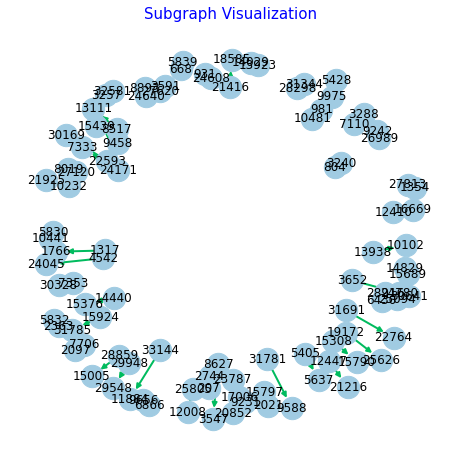

In [23]:
#Subgraph is a subset of vertices and the edges that are between those vertices.

#Creating Subgraph
dataFrameSubgraph = dataFrame.head(50)

#Renaming columns
dataFrameSubgraph = dataFrameSubgraph.rename(columns={"Source": "source", "Destination": "target"})

#Converting edge list to graph
subgraph = nx.from_pandas_edgelist(dataFrameSubgraph, create_using = nx.DiGraph())

#Drawing Graph
pos = nx.spring_layout(subgraph)  
plt.figure(figsize = (8,8))
plt.title('Subgraph Visualization', size = 15, color = 'blue', pad = 3)
nx.draw(subgraph, pos, node_color='#A0CBE2', node_size = 500, edge_color='#00bb5e', width = 2, edge_cmap = plt.cm.Blues, arrows = True, with_labels = True)
plt.savefig('/content/drive/MyDrive/NS Project Dataset/Subgraph Visualization')
plt.show()
#print("Subgraph Details : \n", nx.info(subgraph).split('Name:')[1])

### **C. Exploratory Data Analysis**

#### **No. of Followers For Each Person**

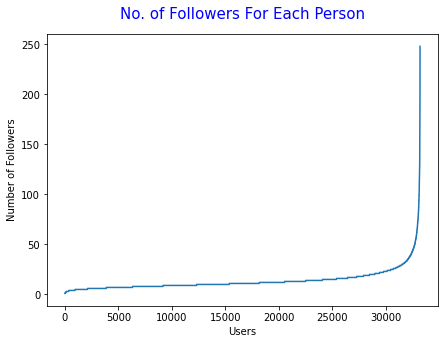

In [24]:
#Followers of a person is all the incoming edges to that person
#Thus we can No. of followers means indegree
#So, indegree means number of peolpe that follows a user
indegreeList = list(dict(original_graph.in_degree()).values())
indegreeList.sort()
plt.figure(figsize=(7,5))
plt.title('No. of Followers For Each Person', size = 15, color = 'blue', pad = 15)
plt.plot(indegreeList)
plt.xlabel('Users')
plt.ylabel('Number of Followers')
plt.savefig('/content/drive/MyDrive/NS Project Dataset/No. of Followers For Each Person.png')
plt.show()
 
#We observe that most of the users have less number of followers.
#But there are some users with extremely high number of followers.

#### **Percentile of Users & Their Followers**

In [25]:
#Only plotted for 90 - 100 percentile
valueList = []
followersList = []
for value in range(0, 11):
  valLine = 90 + value
  valueList.append(valLine)
  followers = np.percentile(indegreeList, 90 + value)
  followersList.append(followers)

followersTable = PrettyTable()
followersTable.title = 'Percentile of Users & Their Followers'
followersTable.field_names = ['Percentile of Users', 'Followers']

for value, followers in zip(valueList, followersList):
  followersTable.add_row([value, followers])
print(followersTable)

+---------------------------------------+
| Percentile of Users & Their Followers |
+-------------------------+-------------+
|   Percentile of Users   |  Followers  |
+-------------------------+-------------+
|            90           |     23.0    |
|            91           |     24.0    |
|            92           |     25.0    |
|            93           |     26.0    |
|            94           |     28.0    |
|            95           |     30.0    |
|            96           |     33.0    |
|            97           |     37.0    |
|            98           |     45.0    |
|            99           |     60.0    |
|           100           |    248.0    |
+-------------------------+-------------+


#### **No. of People Each Person Is Following**

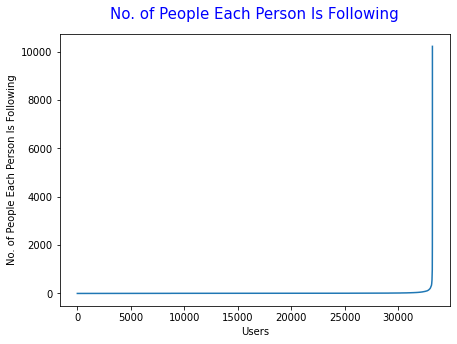

In [26]:
#The number of people a persom follows is all the outgoint edges from that person
#Thus we can No. of people each person is following  means Outdegree
#So, outdegree means number of users a person is following
outdegreeList = list(dict(original_graph.out_degree()).values())
outdegreeList.sort()
plt.figure(figsize=(7,5))
plt.title('No. of People Each Person Is Following', size = 15, color = 'blue', pad = 15)
plt.plot(outdegreeList)
plt.xlabel('Users')
plt.ylabel('No. of People Each Person Is Following')
plt.savefig('/content/drive/MyDrive/NS Project Dataset/No. of People Each Person Is Following.png')
plt.show()
 
#We observe that most of the users follow less number of people.
#But there are some users who follows extremely high number of people.

#### **Percentile of Users & Their Following**

In [27]:
#Only plotted for 90 - 100 percentile
valueList = []
followingList = []
for value in range(0, 11):
  valLine = 90 + value
  valueList.append(valLine)
  following = np.percentile(outdegreeList, (90 + value))
  followingList.append(following)

followingTable = PrettyTable()
followingTable.title = 'Percentile of Users & Their Followings'
followingTable.field_names = ['Percentile of Users', 'Followings']

for value, following in zip(valueList, followingList):
  followingTable.add_row([value, following])
print(followingTable)

+----------------------------------------+
| Percentile of Users & Their Followings |
+-------------------------+--------------+
|   Percentile of Users   |  Followings  |
+-------------------------+--------------+
|            90           |     17.0     |
|            91           |     19.0     |
|            92           |     22.0     |
|            93           |     25.0     |
|            94           |     30.0     |
|            95           |     36.0     |
|            96           |     45.0     |
|            97           |     60.0     |
|            98           |     88.0     |
|            99           |    152.0     |
|           100           |   10226.0    |
+-------------------------+--------------+


#### **More Data Analysis**

#####1. Number of Unique Persons


In [28]:
print("The Number of Unique Persons : ",len(original_graph.nodes()))

The Number of Unique Persons :  33226


##### 2. Number of People Having Zero Followers

In [29]:
zeroFollowers = 0
for value in indegreeList:
  if value == 0:
    zeroFollowers += 1

zeroFollowersPercentage = (zeroFollowers/len(indegreeList) * 100)
print("No. of People Having Zero Followers Are : ", zeroFollowers, '(', round(zeroFollowersPercentage, 2), '%)')

No. of People Having Zero Followers Are :  0 ( 0.0 %)


##### 3. Number of People Having Zero Followings

In [30]:
zeroFollowings = 0
for value in outdegreeList:
  if value == 0:
    zeroFollowings += 1

zeroFollowingsPercentage = (zeroFollowings/len(outdegreeList) * 100)
print("No. of People Having Zero Followings Are : ", zeroFollowings, '(', round(zeroFollowingsPercentage, 2), '%)')

No. of People Having Zero Followings Are :  98 ( 0.29 %)


##### 4. Number of People Having Both Zero Followers And Zero Followings

In [31]:
indegreeDict = dict(original_graph.in_degree())
outdegreeDict = dict(original_graph.out_degree())

bothZero = 0
for degree in indegreeDict:
  if indegreeDict[degree] == 0:
    if outdegreeDict[degree] == 0:
      bothZero += 1

print("Number of Peope Having Both Zero Followers And Zero Followings : ", bothZero)

Number of Peope Having Both Zero Followers And Zero Followings :  0


#### **Indegree Distribution Curve**

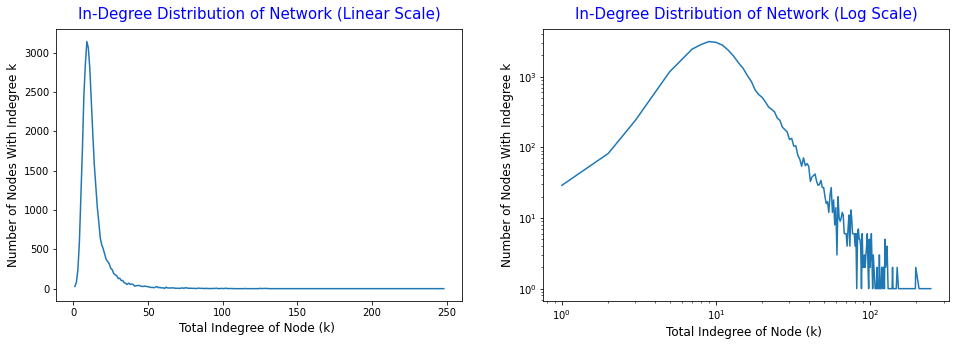

In [35]:
def indegreeDistribution(Graph):
    degreeSequence = sorted([d for n, d in Graph.in_degree()], reverse = True)
    degreeCount = collections.Counter(degreeSequence)
    return degreeCount

indegreeDistributionDict = indegreeDistribution(original_graph)

xIndegreeList = []
yIndegreeList = []

for indegree in sorted(indegreeDistributionDict):
    xIndegreeList.append(indegree)
    yIndegreeList.append(indegreeDistributionDict[indegree])

#Graph
fig = plt.figure(figsize = (16,5))
fig.add_subplot(1,2,1)
plt.title("In-Degree Distribution of Network (Linear Scale)", size = 15, color = 'blue', pad = 10)
plt.plot(xIndegreeList, yIndegreeList)
plt.xlabel("Total Indegree of Node (k) ", fontsize = 12)
plt.ylabel("Number of Nodes With Indegree k", fontsize = 12)
plt.savefig("/content/drive/MyDrive/NS Project Dataset/In-Degree Distribution of Network (Linear Scale)")

fig.add_subplot(1,2,2)
plt.xscale('log')  
plt.yscale('log') 
plt.title("In-Degree Distribution of Network (Log Scale)", size = 15, color = 'blue', pad = 10)
plt.plot(xIndegreeList, yIndegreeList)
plt.xlabel("Total Indegree of Node (k) ", fontsize = 12)
plt.ylabel("Number of Nodes With Indegree k", fontsize = 12)
plt.savefig("/content/drive/MyDrive/NS Project Dataset/In-Degree Distribution of Network (Log Scale)")

plt.show()

#### **Outdegree Distribution Curve**

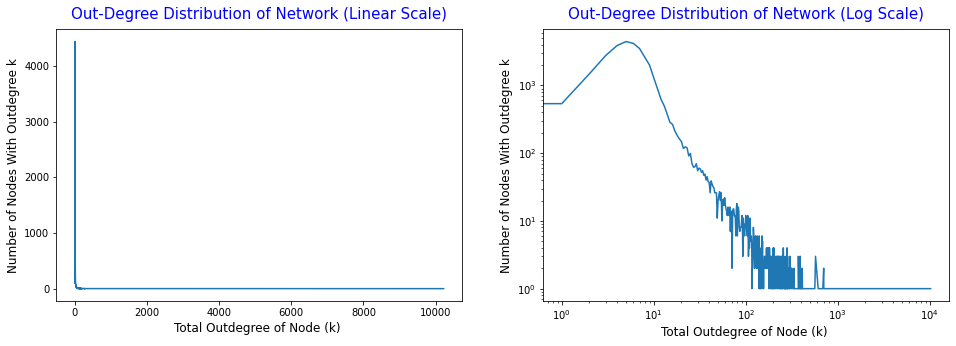

In [36]:
def outdegreeDistribution(Graph):
    degreeSequence = sorted([d for n, d in Graph.out_degree()], reverse = True)
    degreeCount = collections.Counter(degreeSequence)
    return degreeCount

outdegreeDistributionDict = outdegreeDistribution(original_graph)

xOutdegreeList = []
yOutdegreeList = []

for outdegree in sorted(outdegreeDistributionDict):
    xOutdegreeList.append(outdegree)
    yOutdegreeList.append(outdegreeDistributionDict[outdegree])

#Graph
fig = plt.figure(figsize = (16,5))
fig.add_subplot(1,2,1)
plt.title("Out-Degree Distribution of Network (Linear Scale)", size = 15, color = 'blue', pad = 10)
plt.plot(xOutdegreeList, yOutdegreeList)
plt.xlabel("Total Outdegree of Node (k) ", fontsize = 12)
plt.ylabel("Number of Nodes With Outdegree k", fontsize = 12)
plt.savefig("/content/drive/MyDrive/NS Project Dataset/Out-Degree Distribution of Network (Linear Scale)")

fig.add_subplot(1,2,2)
plt.xscale('log')  
plt.yscale('log') 
plt.title("Out-Degree Distribution of Network (Log Scale)", size = 15, color = 'blue', pad = 10)
plt.plot(xOutdegreeList, yOutdegreeList)
plt.xlabel("Total Outdegree of Node (k) ", fontsize = 12)
plt.ylabel("Number of Nodes With Outdegree k", fontsize = 12)
plt.savefig("/content/drive/MyDrive/NS Project Dataset/Out-Degree Distribution of Network (Log Scale)")

plt.show()

### **D. Data Preparation**

#### **Splitting Both Positive & Negative Datasets Into Train & Test**

In [37]:
dataFramePositive = train_data.copy()  #Consists of edges with class 1
dataFrameNegative = negative_edges.copy()  #Consists of edges with class 0

#Separating Class
YPositive = dataFramePositive['Class']
XPositive = dataFramePositive.drop(['Class'], axis = 1)

YNegative = dataFrameNegative['Class']
XNegative = dataFrameNegative.drop(['Class'], axis = 1)

#### **Creating Training & Test Graphs**

In [38]:
#We will create graphs for Positive labelled data only
def createGraph(dataFrame):

  if (len(dataFrame.columns) == 2):
    dataFrame = dataFrame.rename(columns={dataFrame.columns[0]: "source", dataFrame.columns[1] : "target"})
  else:
    print("Invalid Number of Columns.")
    return

  graph = nx.from_pandas_edgelist(dataFrame, create_using = nx.DiGraph())
  return graph

XPositiveGraph = createGraph(XPositive)
print("Number of Nodes In Positive Training Graph : ", len(XPositiveGraph.nodes))
print("Number of Edges In Positive Training Graph : ", len(XPositiveGraph.edges))


Number of Nodes In Positive Training Graph :  33162
Number of Edges In Positive Training Graph :  283623


### **E. Feature Extraction**

#### **Jaccard Similarity**

In [39]:
#Jaccard Similarity For Followers
def jaccard_1(node_u, node_v,g_var):
  try:
    temp=set(g_var.predecessors(node_u))
    temp_1=set(g_var.predecessors(node_v))
    if (len(temp)==0 or len(temp_1)==0):
      return 0
    else: 
      inter_var=len(temp.intersection(temp_1))
      uni_var=len(temp.union(temp_1))
      res=inter_var/uni_var
      return res
  except:
    return 0

#Jaccard Similarity For Followees
def jaccard_2(node_u, node_v,g_var):
  try:
    temp=set(g_var.successors(node_u))
    temp_1=set(g_var.successors(node_v))
    if (len(temp)==0 or len(temp_1)==0):
      return 0
    else:
      inter_var=len(temp.intersection(temp_1))
      uni_var=len(temp.union(temp_1))
      res=inter_var/uni_var
      return res
  except:
    return 0

#### **Cosine Distance**

In [40]:
#Cosine Distance For Followers
def cosine_1(node_u, node_v,g_var):
  try:
    temp=set(g_var.predecessors(node_u))
    temp_1=set(g_var.predecessors(node_v))
    if (len(temp)==0 or len(temp_1)==0):
      return 0
    else:
      inter_var=len(temp.intersection(temp_1))
      uni_var=math.sqrt(len(temp)*len(temp_1))
      res=inter_var/uni_var
      return res
  except:
    return 0

#Cosine Distance For Followees
def cosine_2(node_u, node_v,g_var):
  try:
    temp=set(g_var.successors(node_u))
    temp_1=set(g_var.successors(node_v))
    if (len(temp)==0 or len(temp_1)==0):
      return 0
    else:
      inter_var=len(temp.intersection(temp_1))
      uni_var=math.sqrt(len(temp)*len(temp_1))
      res=inter_var/uni_var
      return res
  except:
    return 0

#### **PageRank**

In [41]:
pr = nx.pagerank(XPositiveGraph, alpha = 0.85)

total = float(sum(pr.values()))
meanPageRankValue = total/len(pr) #For those nodes that are not in training data

#### **Shortest Path**

In [42]:
def spl_fun(node_u, node_v,g_var):
  try:
    #If there is direct edge remove it and then find shortest path
    if g_var.has_listedge(node_u, node_v):
      g_var.remove_edge(node_u, node_v)
      p = nx.shortest_path_length(g_var, source = node_u, target = node_v)
      #Add that edge back
      g_var.add_edge(node_u, node_v)

    else:
      p = nx.shortest_path_length(g_var, source = node_u, target = node_v)
    return p   
  except:
      return -1

#### **Adar Index**

In [43]:
def adar_index(node_u, node_v,g_var):
  sum=0
  try:
    temp=set(g_var.successors(node_u))
    temp_1=set(g_var.successors(node_v))

    inter_var = list(temp.intersection(temp_1))
    if len(inter_var)!=0:
      for i in range(len(inter_var)):
        sum+= (1/np.log10(len(list(g_var.predecessors(inter_var[i])))))

    return sum
  except:
    return 0

#### **Is Person Follows Back**

In [44]:
#It returns 1 if there is an edge from destination to source else 0.
def followsBack(node_u, node_v,g_var):
  
  if g_var.has_edge(node_v, node_u):
    return 1
  else:
    return 0

#### **Katz Centrality**

In [45]:
katz = nx.katz.katz_centrality(XPositiveGraph, alpha = 0.005, beta = 1)

katzTotal = float(sum(katz.values()))
meanKatzCentralityValue = katzTotal/len(katz) #For those nodes that are not in training data

#### **HITS (Hyperlink-Induced Topic Search Score)**

In [46]:
hits = nx.hits(XPositiveGraph, max_iter = 500, tol = 1e-08, nstart = None, normalized = True)

hitsTotal = float(sum(hits[0].values()))
meanHitsScore = hitsTotal/len(hits[0]) #For those nodes that are not in training data

#### **Preferential Attachment**

In [47]:
#Preferential Attachment for Followers
def pref_attachment_1(node_u, node_v,g_var):
  try:
    temp=set(g_var.predecessors(node_u))
    temp_1=set(g_var.predecessors(node_v))

    res=len(temp) * len(temp_1)
    return res
  except:
    return 0

#Preferential Attachment for Followees
def pref_attachment_2(node_u, node_v,g_var):
  try:
    temp=set(g_var.successors(node_u))
    temp_1=set(g_var.successors(node_v))

    res=len(temp) * len(temp_1)
    return res
  except:
    return 0

#### **Common Followers & Followees**

In [48]:
#Common Followers
def common_followers(node_u, node_v,g_var):
  try:
    temp = set(g_var.predecessors(node_u))
    temp_1 = set(g_var.predecessors(node_v))
  except:
    temp = set()
    temp_1 = set()

  res=len(temp.intersection(temp_1))
  return res

#Common Followees
def common_followees(node_u, node_v,g_var):
  try:
    temp = set(g_var.successors(node_u))
    temp_1 = set(g_var.successors(node_v))
  except:
    temp = set()
    temp_1 = set()
    
  res=len(temp.intersection(temp_1))
  return res

#### **Low Rank Approximation Using SVD**

In [49]:
def svd(y, S, adjacencyDict):
  try:
    z = adjacencyDict[y]
    return S[z]
  except:
    return [0] * 6

def lowRankApproximation(df):

  #Creating Adjacency Matrix from Graph
  nodeList = sorted(XPositiveGraph.nodes())
  adjacencyMatrix = nx.adjacency_matrix(XPositiveGraph, nodelist = nodeList).asfptype()
  
  adjacencyDict = { value : index for index , value in enumerate(nodeList)}

  U, s, V = svds(adjacencyMatrix, k = 6)

  #6 Dimensional Feature Vector of Source Node Using U 
  df[['svdUFrom_1', 'svdUFrom_2', 'svdUFrom_3', 'svdUFrom_4', 'svdUFrom_5', 'svdUFrom_6']] = df.Source.apply(lambda y : svd(y, U, adjacencyDict)).apply(pd.Series)

  #6 Dimensional Feature Vector of Destination Node Using U
  df[['svdUTo_1', 'svdUTo_2', 'svdUTo_3', 'svdUTo_4', 'svdUTo_5', 'svdUTo_6']] = df.Destination.apply(lambda y : svd(y, U, adjacencyDict)).apply(pd.Series)

  #6 Dimensional Feature Vector of Source Node Using V
  df[['svdVFrom_1', 'svdVFrom_2', 'svdVFrom_3', 'svdVFrom_4', 'svdVFrom_5', 'svdVFrom_6']] = df.Source.apply(lambda y : svd(y, V.T, adjacencyDict)).apply(pd.Series)

  #6 Dimensional Feature Vector of Destination Node Using V
  df[['svdVTo_1', 'svdVTo_2', 'svdVTo_3', 'svdVTo_4', 'svdVTo_5', 'svdVTo_6']] = df.Destination.apply(lambda y : svd(y, V.T, adjacencyDict)).apply(pd.Series)

  return df

### **Combining DataFrames From positive and negative samples**


In [50]:
X_train = XPositive.append(XNegative, ignore_index = True)
Y_train = YPositive.append(YNegative, ignore_index = True)

print("Shape of X_train : ", X_train.shape)

Shape of X_train :  (453797, 2)


In [51]:
train_df = X_train.copy()
train_df['Class'] = Y_train

#shuffling the data
train_df = train_df.sample(frac = 1).reset_index(drop=True)
train_df.head(5)

,Source,Destination,Class
0,17252,5062,0
1,7706,4851,1
2,2795,26656,1
3,5486,6064,1
4,1819,21425,1


In [52]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

### **Feature DataFrame Creation**


In [53]:
def extract_features(df,graph):
  df['jaccard_1'] = df.apply(lambda row:jaccard_1(row['Source'], row['Destination'],graph), axis=1)
  df['jaccard_2'] = df.apply(lambda row:jaccard_2(row['Source'], row['Destination'],graph), axis=1)

  df['cosine_1'] = df.apply(lambda row:cosine_1(row['Source'], row['Destination'],graph), axis=1)
  df['cosine_2'] = df.apply(lambda row:cosine_2(row['Source'], row['Destination'],graph), axis=1)

  df['Page_Rank0_s'] = df.Source.apply(lambda row: pr.get(row, meanPageRankValue))
  df['Page_Rank0_d'] = df.Destination.apply(lambda row: pr.get(row, meanPageRankValue))

  df['shortest_path'] = df.apply(lambda row: spl_fun(row['Source'], row['Destination'],graph),axis=1)

  df['adar'] = df.apply(lambda row:adar_index(row['Source'], row['Destination'],graph), axis=1)

  df['followsBack'] = df.apply(lambda row: followsBack(row['Source'], row['Destination'],graph),axis=1)

  df['katz_s'] = df['Source'].apply(lambda row: katz.get(row, meanKatzCentralityValue))
  df['katz_d'] = df['Destination'].apply(lambda row: katz.get(row, meanKatzCentralityValue))

  df['hubs_s'] = df['Source'].apply(lambda x: hits[0].get(x, 0))
  df['hubs_d'] = df['Destination'].apply(lambda x: hits[0].get(x, 0))

  df['authorities_s'] = df['Source'].apply(lambda x: hits[1].get(x, 0))
  df['authorities_d'] = df['Destination'].apply(lambda x: hits[1].get(x, 0))

  df['pref_attachment_1'] = df.apply(lambda row:pref_attachment_1(row['Source'], row['Destination'],graph), axis=1)
  df['pref_attachment_2'] = df.apply(lambda row:pref_attachment_2(row['Source'], row['Destination'],graph), axis=1)

  df['common_neighbour_1'] = df.apply(lambda row: common_followers(row['Source'], row['Destination'],graph),axis=1)
  df['common_neighbour_2'] = df.apply(lambda row: common_followees(row['Source'], row['Destination'],graph),axis=1)

  #Low Rank Approximation Using SVD
  df = lowRankApproximation(df)

  return df

In [54]:
train_df = extract_features(train_df,XPositiveGraph)


In [55]:
train_df=clean_dataset(train_df)


#Making Equal No of 0 and 1's in Test_df and Train_df for the target class variable

In [56]:

class_counts = train_df['Class'].value_counts()
class_weights = len(class_counts)/class_counts
train_df = train_df.sample(
    n=class_counts.max()*len(class_counts),
    weights=train_df['Class'].map(class_weights), 
    replace=True)

In [57]:
# train_df = train_df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [91]:
from sklearn.model_selection import train_test_split 
X = train_df.drop('Class', axis =1)
y = train_df['Class']
X_train, X_test, Y_train, Y_test = train_test_split( X,y , test_size = 0.3, random_state = 0) 
print(X_train.shape)
print(X_test.shape)

(397072, 45)
(170174, 45)


In [92]:


print("Shape of X_train : ", X_train.shape)
print("Shape of X_test : ", X_test.shape)

Shape of X_train :  (397072, 45)
Shape of X_test :  (170174, 45)


In [93]:
X_train.head()

,Source,Destination,jaccard_1,jaccard_2,cosine_1,cosine_2,Page_Rank0_s,Page_Rank0_d,shortest_path,adar,...,svdVFrom_3,svdVFrom_4,svdVFrom_5,svdVFrom_6,svdVTo_1,svdVTo_2,svdVTo_3,svdVTo_4,svdVTo_5,svdVTo_6
125128,12460.0,14484.0,0.000000,0.000000,0.000000,0.000000,0.000034,0.000019,-1.0,0.00000,...,-0.000062,-0.000003,-0.000623,-0.000144,0.000139,-0.003234,-0.009370,7.167733e-06,0.002868,-0.006058
76897,16152.0,24064.0,0.000000,0.000000,0.000000,0.000000,0.000031,0.000018,-1.0,0.00000,...,-0.000576,0.000003,-0.002550,-0.000264,0.001918,-0.008653,0.003194,1.809744e-05,0.003822,-0.009690
23851,22323.0,7301.0,0.000000,0.000000,0.000000,0.000000,0.000019,0.000053,-1.0,0.00000,...,0.006837,0.000010,0.000875,-0.012845,0.001107,0.001910,-0.002167,-1.404303e-06,-0.010988,-0.001309
183728,5415.0,5465.0,0.047619,0.000000,0.092450,0.000000,0.000019,0.000068,-1.0,0.00000,...,0.004598,0.000013,-0.005549,-0.013722,-0.003178,0.012087,-0.000938,3.363515e-06,-0.007076,-0.001168
333717,10244.0,11257.0,0.146341,0.014925,0.285391,0.071611,0.000033,0.000022,-1.0,0.69101,...,0.004144,0.000007,0.002817,-0.012416,-0.000235,-0.000067,-0.000135,7.545958e-07,-0.000775,-0.000169


**dropping Source node and destination node from features**

In [94]:
X_train = X_train.drop(['Source', 'Destination'], axis = 1)
X_test = X_test.drop(['Source', 'Destination'], axis = 1)

print('Train data:', (X_train.shape, Y_train.shape))
print('Test data:', (X_test.shape, Y_test.shape))

Train data: ((397072, 43), (397072,))
Test data: ((170174, 43), (170174,))


###**Training ML Models**

**cross-validation**

In [66]:
def cross_validate(model):

  for train_index, test_index in kf.split(X_train):
      x_train, x_val = X_train.iloc[train_index], X_train.iloc[test_index]
      y_train, y_val = Y_train[train_index], Y_train[test_index]

      model.fit(x_train, y_train)
      scores = cross_val_score(model, x_val, y_val, cv=5)
      print("Validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#**Normal Classifiers**

In [67]:
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import matthews_corrcoef,cohen_kappa_score,roc_auc_score
from sklearn.metrics import accuracy_score
def all_metrices(y_test,y_pred):
  acc=accuracy_score(y_test, y_pred)
  auc=roc_auc_score(y_test,y_pred)
  precision=precision_score(y_test, y_pred)
  recall=recall_score(y_test, y_pred)
  f1=f1_score(y_test, y_pred)
  mcc=matthews_corrcoef(y_test,y_pred)
  kappa=cohen_kappa_score(y_test,y_pred)

  print('Accuracy: %.2f' % (acc*100))
  print('Roc_Auc Score: %.2f' % (auc*100))
  print('Precision: %.2f' % (precision*100))
  print('recall: %.2f' % (recall*100))
  print('fl score: %.2f' % (f1*100))
  print('Mcc Score: %.2f' % (mcc))
  print('Kappa score: %.2f' % (kappa))
  print('\n')
  

In [68]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train):
    if train:
        pred = clf.predict(X_train)
        
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        # print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        # print("_______________________________________________")
        # print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        all_metrices(y_train,pred)
    elif train==False:
        pred = clf.predict(X_test)
        
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        # print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        # print("_______________________________________________")
        # print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
        all_metrices(y_test,pred)

In [ ]:
from sklearn.linear_model import LogisticRegression

# lr_clf = LogisticRegression()
# lr_clf.fit(X_train, Y_train)

# print_score(lr_clf, X_train, Y_train, X_test, Y_test, train=True)
# print_score(lr_clf, X_train, Y_train, X_test, Y_test, train=False)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# knn_clf = KNeighborsClassifier()
# knn_clf.fit(X_train, Y_train)

# print_score(knn_clf, X_train, Y_train, X_test, Y_test, train=True)
# print_score(knn_clf, X_train, Y_train, X_test, Y_test, train=False)

In [ ]:
from sklearn.svm import SVC


# svm_clf = SVC(kernel='rbf')
# svm_clf.fit(X_train, Y_train)

# print_score(svm_clf, X_train, Y_train, X_test, Y_test, train=True)
# print_score(svm_clf, X_train, Y_train, X_test, Y_test, train=False)

In [ ]:
from sklearn.tree import DecisionTreeClassifier


# tree_clf = DecisionTreeClassifier(random_state=42)
# tree_clf.fit(X_train, Y_train)

# print_score(tree_clf, X_train, Y_train, X_test, Y_test, train=True)
# print_score(tree_clf, X_train, Y_train, X_test, Y_test, train=False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# rf_clf = RandomForestClassifier(n_estimators=2000, random_state=42)
# rf_clf.fit(X_train, Y_train)
# print_score(rf_clf, X_train, Y_train, X_test, Y_test, train=True)
# print_score(rf_clf, X_train, Y_train, X_test, Y_test, train=False)

In [ ]:
from xgboost import XGBClassifier

# xgb_clf = XGBClassifier()
# xgb_clf.fit(X_train, Y_train)
# print_score(xgb_clf, X_train, Y_train, X_test, Y_test, train=True)
# print_score(xgb_clf, X_train, Y_train, X_test, Y_test, train=False)

#**Varience Based Feature selection results**

In [ ]:
# var =[]
# for i in X_train.columns:
#   temp = np.var(X_train[i])
#   var.append(temp)

# median_var = statistics.mean(var)
# median_var
# selector = VarianceThreshold(median_var)
# X_train_var =selector.fit_transform(X_train)

# X_train_var.shape
# dropped = []

# features = X_train.columns[(selector.get_support())]
# f = (X_train.columns).tolist()
# drop = list(set(f)- set(features))

# for i in drop:
#   dropped.append(i)
# X_test_var = X_test.drop(dropped,axis=1)
# X_test_var.shape

In [ ]:
# from sklearn.linear_model import LogisticRegression

# Models=[LogisticRegression()]
# for model in Models:
#   clf=model
#   clf.fit(X_train_var, Y_train)
#   print_score(clf, X_train_var, Y_train, X_test_var, Y_test, train=True)
#   print_score(clf, X_train_var, Y_train, X_test_var, Y_test, train=False)



#**Correlation Based**

In [ ]:
# cor = X_train.corr()

# # f,ax = plt.subplots(figsize=(14, 14))
# # sns.heatmap(cor, annot=True, linewidths=.5, fmt= '.1f',ax=ax)
# columns = np.full((cor.shape[0],), True, dtype=bool)
# for i in range(cor.shape[0]):
#   for j in range(i+1, cor.shape[0]):
#     if cor.iloc[i,j] >= 0.85:
#       if columns[j]:
#         columns[j] = False

# selected_columns = X_train.columns[columns]
# selected_columns
# X_train_cor = X_train[selected_columns]
# X_train_cor.shape
# X_test_cor = X_test[selected_columns]
# X_test_cor.shape

In [ ]:
# from sklearn.linear_model import LogisticRegression

# Models=[LogisticRegression()]
# for model in Models:
#   clf=model
#   clf.fit(X_train_cor, Y_train)
#   print_score(clf, X_train_cor, Y_train, X_test_cor, Y_test, train=True)
#   print_score(clf, X_train_cor, Y_train, X_test_cor, Y_test, train=False)



#**Recursive Feature Elimination**

In [ ]:
# from sklearn.feature_selection import RFE

# def rfe_selection(model):
#   rfe_selector = RFE(estimator = model, n_features_to_select=10)
#   rfe_selector.fit(X_train, Y_train)

#   rfe_support = rfe_selector.get_support()
#   rfe_feature = X_train.loc[:,rfe_support].columns.tolist()
#   # print(str(len(rfe_feature)), 'selected features')

#   X_train_rfe = X_train[rfe_feature]
#   X_test_rfe = X_test[rfe_feature]

#   return X_train_rfe, X_test_rfe

In [ ]:

# Models=[DecisionTreeClassifier()]
# for model in Models:
#   clf=model
#   X_train_rfe, X_test_rfe=rfe_selection(model)
#   clf.fit(X_train_var, Y_train)
#   print_score(clf, X_train_rfe, Y_train, X_test_rfe, Y_test, train=True)
#   print_score(clf, X_train_rfe, Y_train, X_test_rfe, Y_test, train=False)



#**Pearson Correlation**

In [76]:
#Using Pearson Correlation
# plt.figure(figsize=(200,200))

cor = train_df.corr(method='pearson')
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()
#Correlation with output variable

cor_target= abs(cor['Class'])


#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.15]

print(len(relevant_features))

17


In [77]:
new_df=train_df[relevant_features.keys()]

In [78]:
from sklearn.model_selection import train_test_split 
X = new_df.drop('Class', axis =1)
y = new_df['Class']
X_train, X_test, Y_train, Y_test = train_test_split( X,y , test_size = 0.3, random_state = 0) 
print(X_train.shape)
print(X_test.shape)

(397072, 16)
(170174, 16)


In [79]:
X_train = X_train.drop(['Source', 'Destination'], axis = 1)
X_test = X_test.drop(['Source', 'Destination'], axis = 1)

print('Train data:', (X_train.shape, Y_train.shape))
print('Test data:', (X_test.shape, Y_test.shape))

Train data: ((397072, 14), (397072,))
Test data: ((170174, 14), (170174,))


In [80]:

# train_pearson=train_df[relevant_features.keys()] 
# train_pearson=train_pearson.drop("Class",axis=1)
# # test_pearson=test_df[relevant_features.keys()]
# # test_pearson=test_pearson.drop("Class",axis=1)

In [81]:
print("Relevant_Features",relevant_features.keys())

Relevant_Features Index(['Source', 'Destination', 'Class', 'cosine_1', 'cosine_2',
       'Page_Rank0_d', 'katz_s', 'katz_d', 'hubs_s', 'authorities_s',
       'pref_attachment_1', 'common_neighbour_1', 'svdUFrom_6', 'svdVFrom_2',
       'svdVFrom_5', 'svdVFrom_6', 'svdVTo_5'],
      dtype='object')


In [82]:
import pickle
Models=[LogisticRegression(),KNeighborsClassifier(),DecisionTreeClassifier(),RandomForestClassifier(),XGBClassifier()]
i=0
for model in Models:
  print("Model is : ", model)
  clf=model
  clf.fit(X_train, Y_train)

  if(i==3):
    pickle. dump(clf, open("/content/drive/MyDrive/RandomForest model for NS Project/RandomForestModel.sav", 'wb'))
  i=i+1
  print_score(clf, X_train, Y_train, X_test, Y_test, train=True)
  print_score(clf, X_train, Y_train, X_test, Y_test, train=False)



Model is :  LogisticRegression()


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Train Result:
_______________________________________________
Confusion Matrix: 
 [[187289  11229]
 [ 57074 141480]]

Accuracy: 82.80
Roc_Auc Score: 82.80
Precision: 92.65
recall: 71.26
fl score: 80.56
Mcc Score: 0.67
Kappa score: 0.66


Test Result:
_______________________________________________
Confusion Matrix: 
 [[80489  4668]
 [24492 60525]]

Accuracy: 82.86
Roc_Auc Score: 82.86
Precision: 92.84
recall: 71.19
fl score: 80.59
Mcc Score: 0.68
Kappa score: 0.66


Model is :  KNeighborsClassifier()
Train Result:
_______________________________________________
Confusion Matrix: 
 [[186444  12074]
 [ 17257 181297]]

Accuracy: 92.61
Roc_Auc Score: 92.61
Precision: 93.76
recall: 91.31
fl score: 92.52
Mcc Score: 0.85
Kappa score: 0.85


Test Result:
_______________________________________________
Confusion Matrix: 
 [[77056  8101]
 [10949 74068]]

Accuracy: 88.81
Roc_Auc Score: 88.80
Precision: 90.14
recall: 87.12
fl score: 88.61
Mcc Score: 0.78
Kappa score: 0.78


Model is :  DecisionTre

#**A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.**

#**HyperParameter_tuning**

In [ ]:
# grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

# # Create grid search object

# clf = GridSearchCV(LogisticRegression(), param_grid = grid, cv = 5, verbose=True, n_jobs=-1)

# # Fit on data

# best_clf = clf.fit(train_pearson, Y_train)
# print("tuned hpyerparameters :(best parameters) ",best_clf.best_params_)
# print("accuracy :",best_clf.best_score_)

In [ ]:
# clf=LogisticRegression(C= 0.001, penalty='l2')
# clf.fit(train_pearson, Y_train)
# print_score(clf, train_pearson, Y_train, test_pearson, Y_test, train=True)
# print_score(clf, train_pearson, Y_train, test_pearson, Y_test, train=False)

In [ ]:
# tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
# clf = GridSearchCV(DecisionTreeClassifier(), param_grid = tree_para, cv = 5, verbose=True, n_jobs=-1)

# # Fit on data

# best_clf = clf.fit(train_pearson, Y_train)
# print("tuned hpyerparameters :(best parameters) ",best_clf.best_params_)
# print("accuracy :",best_clf.best_score_)

In [ ]:
# clf=DecisionTreeClassifier(criterion="entropy",max_depth=70)
# clf.fit(train_pearson, Y_train)
# print_score(clf, train_pearson, Y_train, test_pearson, Y_test, train=True)
# print_score(clf, train_pearson, Y_train, test_pearson, Y_test, train=False)

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# k_range = list(range(1, 31))
# param_grid = dict(n_neighbors=k_range)
# clf = GridSearchCV(KNeighborsClassifier(), param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

# # Fit on data

# best_clf = clf.fit(train_pearson, Y_train)
# print("tuned hpyerparameters :(best parameters) ",best_clf.best_params_)
# print("accuracy :",best_clf.best_score_)


In [ ]:
# clf = KNeighborsClassifier(n_neighbors=)

# clf.fit(train_pearson, Y_train)
# print_score(clf, train_pearson, Y_train, test_pearson, Y_test, train=True)
# print_score(clf, train_pearson, Y_train, test_pearson, Y_test, train=False)

In [ ]:
# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy']
# }
# clf = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

# # Fit on data

# best_clf = clf.fit(train_pearson, Y_train)
# print("tuned hpyerparameters :(best parameters) ",best_clf.best_params_)
# print("accuracy :",best_clf.best_score_)

In [ ]:
# clf=RandomForestClassifier(random_state=42, max_features='', n_estimators= , max_depth=, criterion='')
# clf.fit(train_pearson, Y_train)
# print_score(clf, train_pearson, Y_train, test_pearson, Y_test, train=True)
# print_score(clf, train_pearson, Y_train, test_pearson, Y_test, train=False)

#**Vislualization**

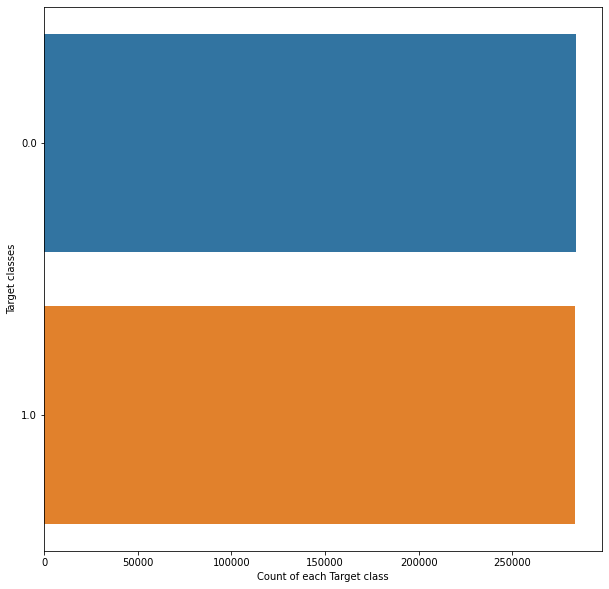

In [83]:
plt.figure(figsize=(10,10))
sns.countplot(y=new_df['Class'] ,data=new_df)

plt.xlabel("Count of each Target class")
plt.ylabel("Target classes")
plt.show()

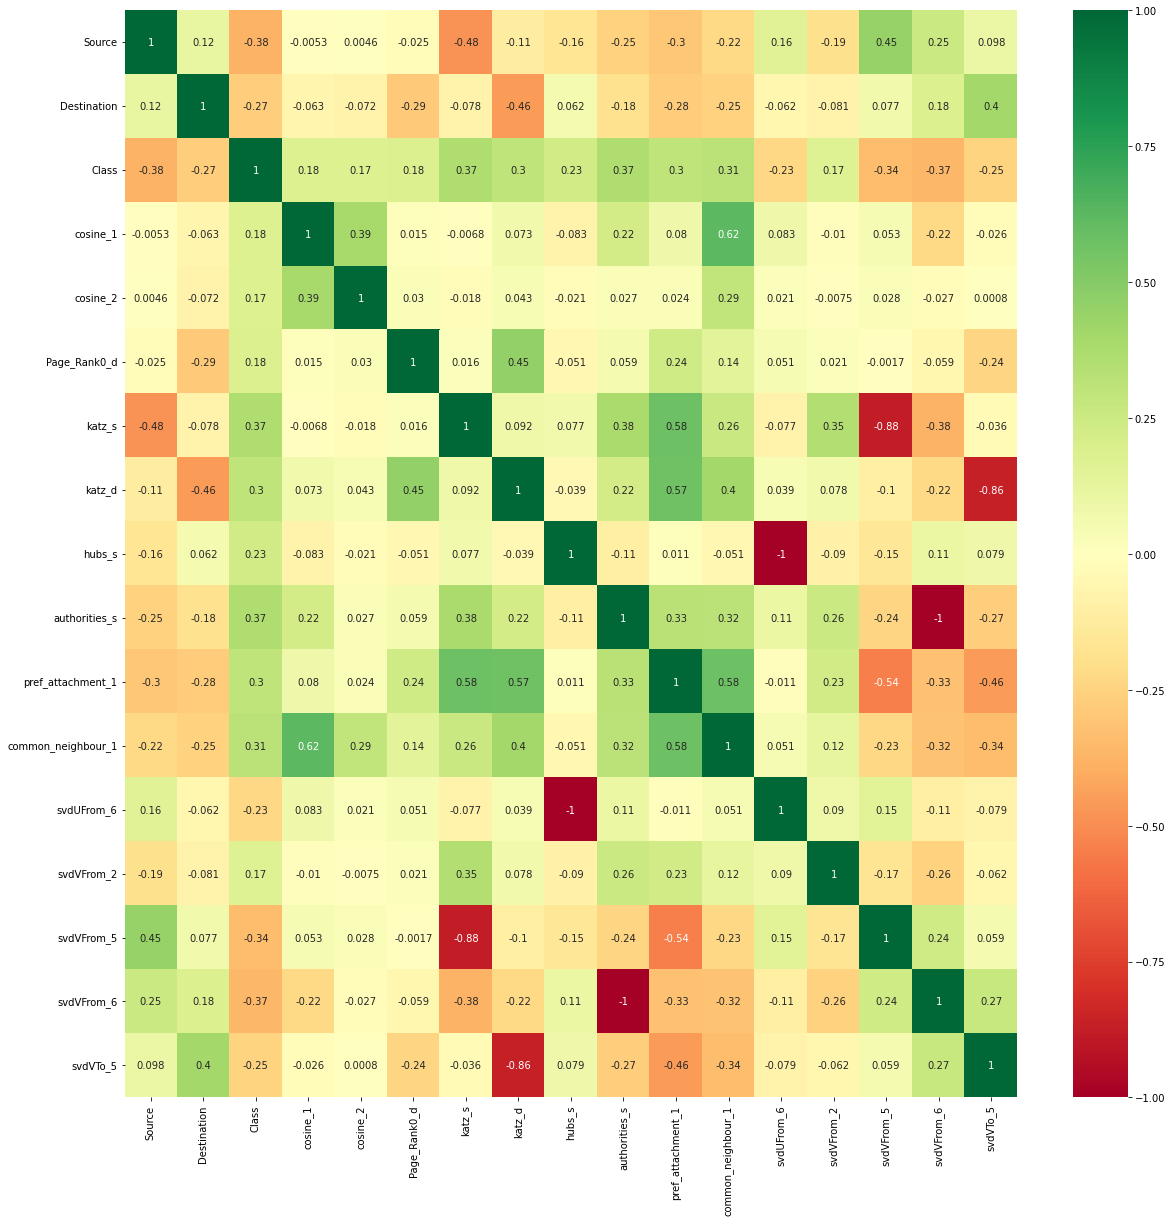

In [84]:
#Correlation Matrix with Heatmap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#get correlations of each features in dataset
corrmat =new_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(new_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

[0.06569119 0.04996335 0.03327166 0.02698401 0.04518245 0.06330773
 0.04998535 0.16495496 0.06107827 0.04877848 0.03492049 0.1717509
 0.02274508 0.05160074 0.06699963 0.0427857 ]


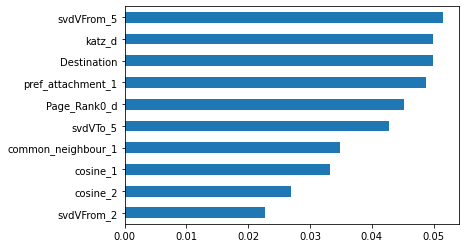

In [85]:
#Feature Importance By smallest connection
import pandas as pd
import numpy as np


from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nsmallest(10).plot(kind='barh')
plt.show()

[0.02969164 0.02701744 0.0223576  0.02526692 0.05057563 0.03951567
 0.04446236 0.18422871 0.01975533 0.09125253 0.02406547 0.31459209
 0.01810709 0.03580391 0.02756112 0.04574648]


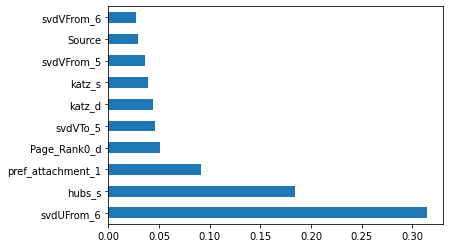

In [86]:
#Feature Importance By largest connection
import pandas as pd
import numpy as np


from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
model = RandomForestClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19a8c1bd90>,
      dtype=object)

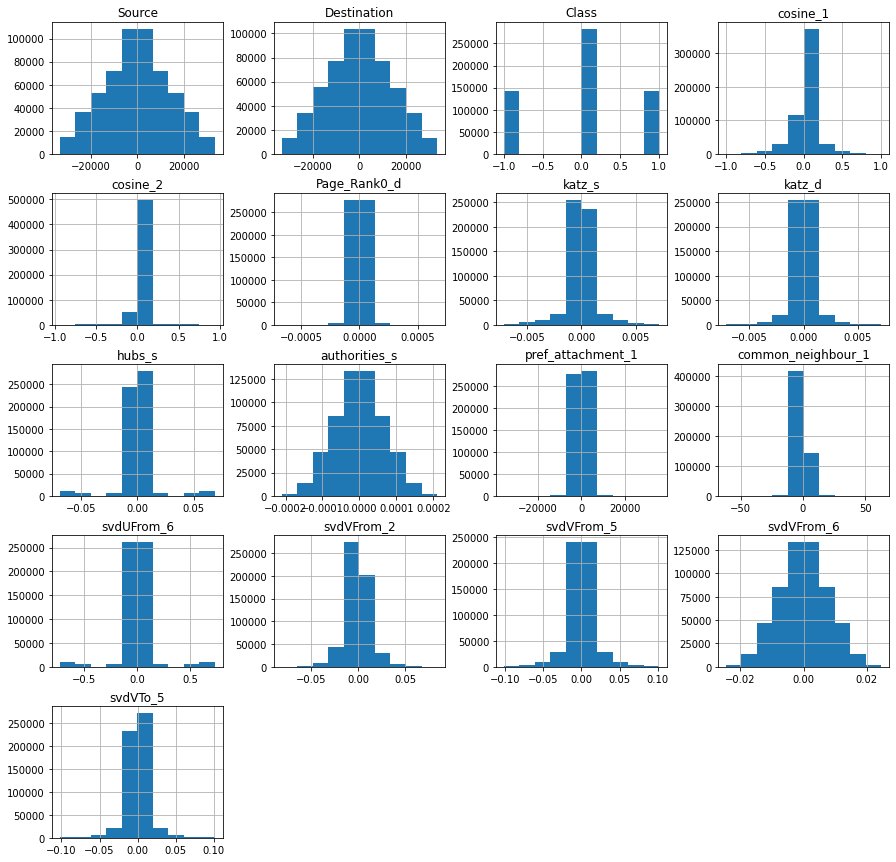

In [87]:
new_df.diff().hist(figsize=(15, 15))

#Creating Test DataFrame

In [98]:
test_data=pd.read_csv("/content/drive/MyDrive/NS Project Dataset/testing.txt", sep=" ", header=None, names= ["source", "target"])
g1 = nx.from_pandas_edgelist(test_data, create_using = nx.Graph())
print(nx.is_connected(g1))
print(nx.number_connected_components(g1))
test_data = test_data.rename(columns={"source": "Source", "target": "Destination"})
test_data.groupby(['Source','Destination']).ngroups
test_data = test_data.drop_duplicates()
test_data= test_data.dropna()
test_data.shape
test_graph = nx.DiGraph()

for index,row in tqdm(test_data.iterrows()):
  source = row['Source']
  dest =  row['Destination']
  test_graph.add_edge(source,dest)

print(nx.info(test_graph))
test_labels = np.ones(len(test_graph.edges()), dtype = int)
test_labels = test_labels.tolist()

test_data['Class'] = test_labels
print(test_data.shape)
test_data.head(2)
edge_count = 0
negative_list = []
nodesList = list(test_graph.nodes())

while edge_count < (len(test_graph.edges())/4):
  u = random.choice(nodesList)
  v = random.choice(nodesList)

  if u!=v and test_graph.has_edge(u,v) == False:
    try:
      #Add edge to negative edge only if shortest path between u and v is greater than 2
      if nx.shortest_path_length(test_graph, source = u, target = v) > 2:
        negative_list.append((u,v,0))
        edge_count +=1

    except Exception as e:
      negative_list.append((u,v,0))
      edge_count +=1

negative_edges_test = pd.DataFrame(negative_list, columns = ['Source', 'Destination', 'Class'])
print(negative_edges_test.shape)
negative_edges_test.head(2)
labeled_test_data = pd.concat([test_data,negative_edges_test])
print(labeled_test_data.shape)
labeled_test_data.head(2)

#randomly shuffle test data
labeled_test_data = labeled_test_data.sample(frac = 1).reset_index(drop=True)
labeled_test_data.head(5)
test_df = labeled_test_data.copy()
Y_test = labeled_test_data['Class']

test_df.head(5)
test_df = extract_features(test_df,test_graph)
test_df=clean_dataset(test_df)
class_counts1 = test_df['Class'].value_counts()
class_weights1 = len(class_counts1)/class_counts1
test_df = test_df.sample(
    n=class_counts1.max()*len(class_counts1),
    weights=test_df['Class'].map(class_weights1), 
    replace=True)

test_df=test_df[relevant_features.keys()]
test_df.to_csv("/content/drive/MyDrive/RandomForest model for NS Project/TestingDataframe.csv")
negative_features = extract_features(negative_edges_test,test_graph)
negative_features=negative_features[relevant_features.keys()]
negative_features.to_csv('/content/drive/MyDrive/RandomForest model for NS Project/negative_edges_features.csv', index = False)

False
10


113450it [00:12, 8914.74it/s] 


DiGraph with 32740 nodes and 113450 edges
(113450, 3)
(28363, 3)
(141813, 3)
